## Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

In [1]:
# %reset

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [3]:
import sys

In [4]:
# in order to import libraries
sys.path.append("C:/Users/user/Documents/Salamat/fastai")

In [5]:
sys.path

['',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\python36.zip',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\DLLs',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib\\site-packages',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib\\site-packages\\cycler-0.10.0-py3.6.egg',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\user\\.ipython',
 'C:/Users/user/Documents/Salamat/fastai']

In [6]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [8]:
PATH = "C:/Users/user/Documents/Salamat"
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [9]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [10]:
torch.backends.cudnn.enabled

True

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [11]:
os.listdir(PATH)

['ELO',
 'fastai',
 'fastai3',
 'Kaggle',
 'models',
 'NDSC_2019',
 'NDSC_2019train_beaty.csv',
 'NDSC_2019train_beauty.csv',
 'Programs',
 'tmp',
 'train_beauty.csv',
 'train_beauty2.csv']

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

# Finally, let's do for fashion

In [12]:
arch=resnet34

In [14]:
PATH_beauty='C:/Users/user/Documents/Salamat/NDSC_2019/beauty'
os.listdir(PATH_beauty)

['models', 'test', 'tmp', 'train', 'val']

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [25]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [26]:
PATH='C:\\Users\\user\\Documents\\Salamat\\NDSC_2019\\beauty'

In [27]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [28]:
ims = np.stack([get_augs() for i in range(6)])

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


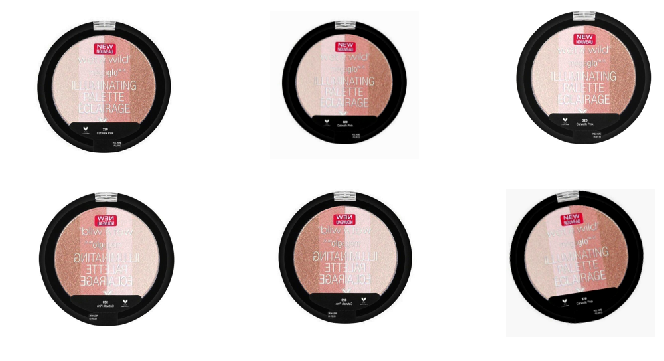

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [29]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [31]:
data_beauty = ImageClassifierData.from_paths(path=PATH_beauty,tfms=tfms,trn_name='train',val_name='valid', test_name='test')

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [32]:
learn_beauty = ConvLearner.pretrained(arch, data_beauty, precompute=True)

In [33]:
learn_beauty.fit(1e-2, 1)

 20%|█████████████▏                                                     | 704/3583 [00:06<00:27, 103.37it/s, loss=1.63]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.518083   1.406861   0.551302  


[array([1.40686]), 0.5513024059183874]

In [34]:
learn_beauty.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [35]:
learn_beauty.fit(1e-2, 3, cycle_len=1)

  0%|▎                                                                    | 15/3583 [00:07<28:37,  2.08it/s, loss=1.56]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|███████▍                                                            | 394/3583 [02:49<22:54,  2.32it/s, loss=1.51]

KeyboardInterrupt: 

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

In [ ]:
learn_beauty.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [ ]:
learn_beauty.save('beauty_lastlayer')

In [ ]:
learn_beauty.load('beauty_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [ ]:
learn_beauty.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn_beauty.fit(lr, 3, cycle_len=1, cycle_mult=2)

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [ ]:
learn_beauty.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [ ]:
learn_beauty.save('all_beauty_lastlayer')

In [ ]:
learn_beauty.load('all_beauty_lastlayer')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds,y = learn_beauty.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
# We have improved quite significantly
accuracy_np(probs, y)

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [54]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[   2  260   65   33    0    2    2    0   86   78   19    6    0    0]
 [   0 9498  223  593   25   55   11    1  341  444   72   45   11    0]
 [   0 1640  586  267    8   10   15    0   32  128    8    3    2    0]
 [   0 2282  175 1347    0    1   15    0   47  114   13    2    0    0]
 [   0 1783   37  101   32    7    4    0   41   77    7    7    1    0]
 [   0 2614   82  108    1   79    2    0   68   78    3    8    2    0]
 [   0   92   43   55    0    0  136    0    2    6    0    0    0    0]
 [   0  615   21  132    4    0    0    5   27   40    5    1    0    0]
 [   0  705    3   12    0    2    0    0 4503 1352   97   91   19    0]
 [   0 1168   38   55    0   10    0    0 1231 3846  307   92   22    0]
 [   0  469    8   10    0    0    0    0  519 1387  824   16    7    0]
 [   0  335    2   13    0    0    0    0  205  258    5  446   35    0]
 [   0  115    2    1    0    1    0    0  158  200    3   89   99    0]
 [   0   70    0    2    0    0    0    0   55  138

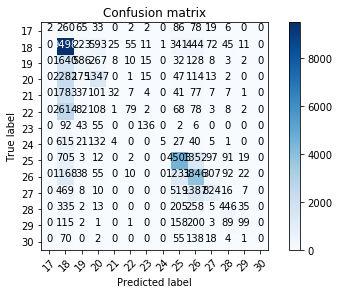

In [56]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [52]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cow")

NameError: name 'plot_val_with_title' is not defined

In [53]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect sheep")

NameError: name 'plot_val_with_title' is not defined

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [114]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [115]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [116]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters*  are learned by fitting a model to the data. *Hyparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [117]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.046303   0.026076   0.989     



[array([0.02608]), 0.989]

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [118]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [119]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.